# Coarrays, MUSIC, and the Cramér-Rao bound

This notebook contains scripts for analyzing the performance of SS-MUSIC and DA-MUSIC for various sparse linear arrays. You can use these scripts to produce figures similar to those in the following papers:

```
@article{wang_coarrays_2017,
    title = {Coarrays, {MUSIC}, and the {Cram\'{e}r}-{Rao} Bound},
    volume = {65},
    issn = {1053-587X},
    doi = {10.1109/TSP.2016.2626255},
    number = {4},
    journal = {IEEE Trans. Signal Process.},
    author = {Wang, M. and Nehorai, A.},
    month = feb,
    year = {2017},
    pages = {933--946}
}
@inproceedings{wang_performance_2017,
    title = {Performance analysis of coarray-based {MUSIC} and the {Cram\'{e}r}-{Rao} bound},
    doi = {10.1109/ICASSP.2017.7952719},
    booktitle = {2017 {IEEE} {International} {Conference} on {Acoustics}, {Speech} and {Signal} {Processing} ({ICASSP})},
    author = {Wang, M. and Zhang, Z. and Nehorai, A.},
    month = mar,
    year = {2017},
    pages = {3061--3065}
}
```

In [1]:
import numpy as np
import doatools.model as model
import doatools.estimation as estimation
import doatools.performance as perf
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
%matplotlib inline

In [8]:
# Common parameters
wavelength = 1.0 # normalized
d0 = wavelength / 2.0

# Arrays
arrays = [
    model.CoPrimeArray(3, 5, d0, '2m', 'Co-prime Array'),
    model.NestedArray(4, 6, d0, 'Nested Array'),
    model.MinimumRedundancyLinearArray(10, d0, 'MRA')
]
n_arrays = len(arrays)

## Numerical demonstration of the analytical MSE

We compare the analytical MSE,
\begin{equation}
\mathrm{MSE}_{\mathrm{an}} = \frac{1}{K} \sum_{k=1}^K \epsilon(\theta_k),
\end{equation}
with the empirical MSE
\begin{equation}
\mathrm{MSE}_{\mathrm{em}} = \frac{1}{KL} \sum_{l=1}^L\sum_{k=1}^K(\hat{\theta}_k^{(l)} - \theta_k^{(l)})^2,
\end{equation}
where $\epsilon(\theta_k)$ is defined in (11), $\theta_k^{(l)}$ is the $k$-th DOA in the $l$-th trial, and $\theta_k^{(l)}$ is the corresponding estimate.

In [9]:
# Setup
sources = model.FarField1DSourcePlacement(np.linspace(-np.pi*6/16, np.pi*5/16, 11))
power_source = 1.0

n_param_n_snapshots = 20
n_param_snr = 20

min_n_snapshots = 10
max_n_snapshots = 1000
min_snr = -20.0
max_snr = 20.0

params_n_snapshots = np.round(np.linspace(min_n_snapshots, max_n_snapshots, n_param_n_snapshots)).astype(np.int32)
params_snr = np.linspace(min_snr, max_snr, n_param_snr)
rv_modes = ['da', 'ss']

Here we set `n_repeats` to 100, which means each point in the final plots is averaged from 100 trials. The simulation will take 30-60 minutes depending on your CPU. The resulting plots will be noiser compared with Fig. 2 in the paper.

You need to increase `n_repeats` to at least 5000 to obtain plots as clean as those in Fig. 2. The original scripts were written in MATLAB and utilized `parfor`, which were scalable on clusters. However, implementing `parfor` is not an easy task in Python, and running the full-scale simulations with a single CPU can be very time consuming.

In [20]:
# Run Monte Carlo simulations.
n_repeats = 100

results_em = np.zeros((n_arrays, 2, n_param_n_snapshots, n_param_snr))
results_an = np.zeros((n_arrays, 2, n_param_n_snapshots, n_param_snr))

source_signal = model.ComplexStochasticSignal(sources.size, power_source)
coarray_acm_builders = [estimation.CoarrayACMBuilder1D(arr) for arr in arrays]
root_music = estimation.RootMUSIC1D(wavelength)

# We have 4 varying parameters here. Pardon us for these for loops :)
with tqdm(total=results_em.size) as pbar:
    for dd, array in enumerate(arrays):
        for ss, rv_mode in enumerate(rv_modes):
            for ii, n_snapshots in enumerate(params_n_snapshots):
                for jj, snr in enumerate(params_snr):
                    power_noise = 10**(-snr/10) * np.min(power_source)
                    noise_signal = model.ComplexStochasticSignal(array.size, power_noise)
                    cur_mse = 0
                    for rr in range(n_repeats):
                        _, R = model.get_narrowband_snapshots(array, sources, wavelength, source_signal, noise_signal,
                                                              n_snapshots, return_covariance=True)
                        Rv = coarray_acm_builders[dd](R, rv_mode)
                        _, estimates = root_music.estimate(Rv, sources.size, d0)
                        cur_mse += np.sum((estimates.locations - sources.locations)**2)
                    results_em[dd, ss, ii, jj] = cur_mse / (n_repeats * sources.size)
                    C_an = perf.ecov_coarray_music_1d(array, sources, wavelength, power_source, power_noise, n_snapshots)
                    results_an[dd, ss, ii, jj] = np.mean(np.diag(C_an))
                    pbar.update(1)

rel_errors = np.abs(results_an - results_em) / results_em

  0%|          | 0/2400 [3:54:16<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Plot the results.
plt.figure(figsize=(7, 8))

bounds = (params_snr[0], params_snr[-1], params_n_snapshots[-1], params_n_snapshots[0])
for dd, array in enumerate(arrays):
    # Left
    ax = plt.subplot(n_arrays, 2, dd * 2 + 1)
    plt.imshow(rel_errors[dd, 0, :, :], extent=bounds, aspect='auto',
               cmap='gray_r', vmin=0.0, vmax=1.0)
    ax.invert_yaxis()
    plt.colorbar()
    if dd == n_arrays - 1:
        plt.xlabel('SNR (dB)')
    plt.ylabel('Number of snapshots')
    plt.title(arrays[dd].name + ' (DA-MUSIC)')
    
    # Right
    ax = plt.subplot(n_arrays, 2, dd * 2 + 2);
    plt.imshow(rel_errors[dd, 1, :, :], extent=bounds, aspect='auto',
               cmap='gray_r', vmin=0.0, vmax=1.0)
    ax.invert_yaxis()
    plt.colorbar()
    if dd == n_arrays - 1:
        plt.xlabel('SNR (dB)')
    plt.ylabel('Number of snapshots')
    plt.title(arrays[dd].name + ' (SS-MUSIC)')

plt.tight_layout()
plt.show()

## Prediction of resolvability

For illustration purpose, we analytically predict the resolvability of the two sources via the following simple criterion:

\begin{equation}
    \epsilon(\theta_1) + \epsilon(\theta_2) 
    \underset{\mathrm{Resolvable}}{\overset{\mathrm{Unresovalble}}{\gtreqless}} \Delta\theta.
\end{equation}

In [5]:
# Setups
power_source = 1.0
power_noise = 1.0 # SNR = 0 dB
n_snapshots = 500
n_repeats = 500

theta_0 = np.pi/6
delta_thetas = np.linspace(np.pi/60, np.pi/600, 20);

In [7]:
# Helper functions.
def check_doa_correctness(actual, est, tolerance=np.inf):
    '''Checks if estimated doa is reasonably close to the actual ones.
    
    Input must be in ascending order within range of (-pi/2, pi/2).
    
    More precisely, suppose the true DOAs are x_1, x_2, ..., x_k, the estimated
    DOAs must fall within the following regions:
    (-pi/2, x_1 + (x_2 - x_1) / 2),
    (x_1 + (x_2 - x_1) / 2, x_2 + (x_3 - x_2) / 2), ...
    (x_k - (x_k - x_{k-1}) / 2, pi/2)
    If tolerance is not inf, the estimated DOAs must also fall within the following
    regions:
    (x_1 - tolerance, x_1 + tolerance), ...
    (x_k - tolerance, x_k + tolerance)
    '''
    n = actual.size
    # Size mismatches.
    if n != est.size:
        return False
    # Special case: one source only.
    if n == 1:
        return np.abs(actual[0] - est[0]) < tolerance
    # General case
    spaces = np.diff(actual)
    max_deviations = np.minimum(0.5 * spaces, tolerance)
    # First
    if est[0] < max(-np.pi / 2, actual[0] - tolerance) or \
       est[0] > actual[0] + max_deviations[0]:
        return False 
    # Last
    if est[-1] > min(np.pi / 2, actual[-1] + tolerance) or \
       est[-1] < actual[-1] - max_deviations[-1]:
        return False
    # Middle parts
    for i in range(1, n - 1):
        if est[i] < actual[i] - max_deviations[i - 1] or \
           est[i] > actual[i] + max_deviations[i]:
            return False
    return True

def check_resolution_ana(array, wavelength, doa1, doa2, power_source, power_noise, n_snapshots, l=1.0):
    '''Checks if two sources are resolvable analytically with SS-MUSIC
    (or DA-MUSIC) using the analytical asymptotic MSE we derived in (11)
    after Theorem 1.
    '''
    # Ensure doa1 < doa2
    if doa1 > doa2:
        doa1, doa2 = doa2, doa1
    sources = model.FarField1DSourcePlacement([doa1, doa2])
    C = perf.ecov_coarray_music_1d(array, sources, wavelength, power_source, power_noise, n_snapshots)
    # Apply the resolution criterion
    return doa2 - doa1 > l * (np.sqrt(C[0, 0]) + np.sqrt(C[1, 1]))

In [8]:
# Run Monte Carlo simulations.
resolution_success_rate = np.zeros((n_arrays, delta_thetas.size))
resolution_threshold_ana = np.zeros((n_arrays,))

coarray_acm_builders = [estimation.CoarrayACMBuilder1D(arr) for arr in arrays]
root_music = estimation.RootMUSIC1D(wavelength)

with tqdm(total=resolution_success_rate.size) as pbar:
    for dd, array in enumerate(arrays):
        source_signal = model.ComplexStochasticSignal(2, power_source)
        noise_signal = model.ComplexStochasticSignal(array.size, power_noise)
        # Marks unresolvable separations predicted by the analytical results.
        unresolvable_flags = np.zeros((delta_thetas.size,))
        for ii, delta_theta in enumerate(delta_thetas):
            theta_1 = theta_0 - 0.5 * delta_theta
            theta_2 = theta_0 + 0.5 * delta_theta
            # Analytically check the minimal resolvable delta.
            unresolvable_flags[ii] = not check_resolution_ana(array, wavelength, theta_1, theta_2,
                                                              power_source, power_noise, n_snapshots)
            # Collect the empirical success rate.
            n_successes = 0
            sources = model.FarField1DSourcePlacement([theta_1, theta_2])
            for rr in range(n_repeats):                
                _, R = model.get_narrowband_snapshots(array, sources, wavelength, source_signal, noise_signal,
                                                      n_snapshots, return_covariance=True)
                Rv = coarray_acm_builders[dd](R, 'ss')
                _, estimates = root_music.estimate(Rv, 2, array.d0)
                # Requires accurate resolution.
                if check_doa_correctness(sources.locations, estimates.locations, 0.5 * delta_theta):
                    n_successes += 1
            resolution_success_rate[dd, ii] = n_successes / n_repeats
            pbar.update(1)
        min_delta_ana_idx = np.argmax(unresolvable_flags > 0)
        if unresolvable_flags[min_delta_ana_idx] == 0:
            resolution_threshold_ana[dd] = delta_thetas[0]
        else:
            resolution_threshold_ana[dd] = delta_thetas[min_delta_ana_idx]

100%|██████████| 60/60 [00:53<00:00,  1.12it/s]


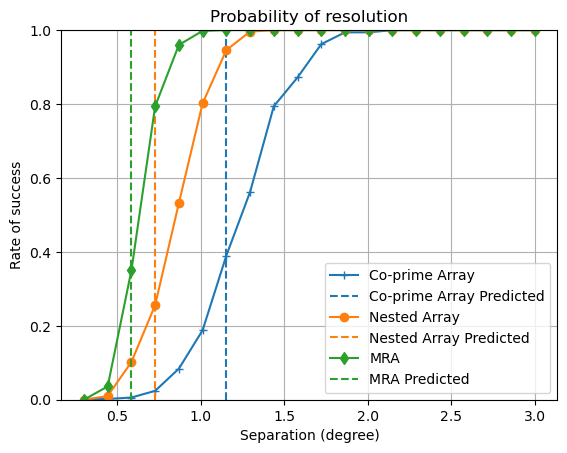

In [9]:
# Plot the results.
plt.figure()
markers = ['+', 'o', 'd', '*']
for dd, array in enumerate(arrays):
    plt.plot(np.rad2deg(delta_thetas), resolution_success_rate[dd,:], '-' + markers[dd],
                 label=array.name, color='C' + str(dd))
    plt.gca().set_ylim((0, 1))
    ana_threshold = np.rad2deg(resolution_threshold_ana[dd])
    plt.plot([ana_threshold, ana_threshold], [0, 1], '--',  color='C' + str(dd),
             label=array.name + ' Predicted')
plt.xlabel('Separation (degree)')
plt.ylabel('Rate of success')
plt.title('Probability of resolution')
plt.legend()
plt.grid(True)
plt.show()

## Efficiency analysis

We study the asymptotic statistical efficiency of DA-MUSIC and SS-MUSIC under different array geometries and parameter settings. We define their average efficiency as

\begin{equation}
    \kappa = \frac{\mathrm{tr}(\mathrm{CRB}_{\boldsymbol{\theta}})}{\sum_{k=1}^K \epsilon(\theta_k)}.
\end{equation}

For efficient estimators we expect $\kappa = 1$, while for inefficient estimators we expect $0 \leq \kappa < 1$.

In [10]:
# Setup
n_snapshots = 1 # normalized
power_source = 1.0
snrs = np.linspace(-10, 20, 30)
n_snrs = snrs.size

source_numbers = [1, 6, 12]
n_experiments = len(source_numbers)

In [11]:
# Evaluate the statistical efficiency under difference SNRs.
e1 = np.zeros((n_arrays, n_snrs, n_experiments))
e2 = np.zeros((n_arrays, n_snrs, n_experiments))
for kk, n_sources in enumerate(source_numbers):
    sources = model.FarField1DSourcePlacement(
        np.linspace(-np.pi / 3, np.pi / 3, n_sources))
    for dd, array in enumerate(arrays):
        for ii, snr in enumerate(snrs):
            power_noise = power_source * 10**(-snr/10)
            # Asymptotic covariance matrix
            C = perf.ecov_coarray_music_1d(array, sources, wavelength, power_source,
                                           power_noise, n_snapshots)
            # CRB
            B = perf.crb_stouc_farfield_1d(array, sources, wavelength, power_source,
                                           power_noise, n_snapshots)
            e1[dd, ii, kk] = np.sum(np.diag(C))
            e2[dd, ii, kk] = np.sum(np.diag(B))
            
efficiency = e2 / e1

C:\Users\A\AppData\Local\Temp\ipykernel_22192\2707978995.py:11: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.axis([-10, 20, 0, 1])


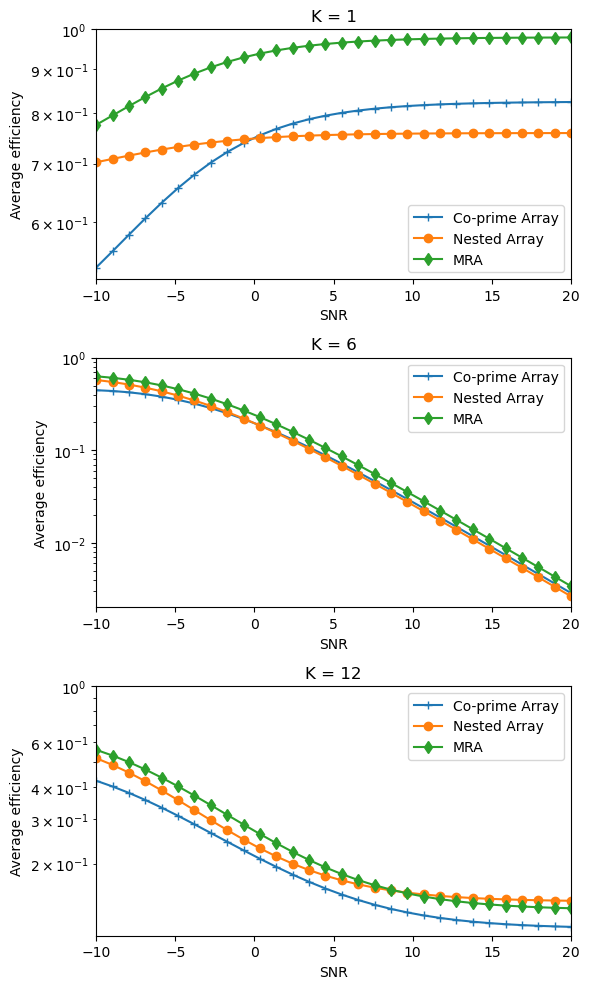

In [13]:
# Plot
plt.figure(figsize=(6, 10))
for kk, n_sources in enumerate(source_numbers):
    plt.subplot(n_experiments, 1, kk + 1)
    markers = ['+', 'o', 'd', '*']
    for dd, array in enumerate(arrays):
        hp = plt.plot(snrs, efficiency[dd, :, kk], '-' + markers[dd], label=array.name)
    plt.xlabel('SNR')
    plt.ylabel('Average efficiency')
    plt.yscale('log')
    plt.axis([-10, 20, 0, 1])
    plt.title('K = {0:d}'.format(n_sources))
    plt.legend()
plt.tight_layout()
plt.show()